<h2> Analysis of Grip Strength in MrOS V1 Data (EDA3-V1-GS.ipynb) </h2> 

The purpose of this workbook is take begin exploring the vast amount of data that we have.  Through various methods of exploration, we hope to find general trends, patterns, and correlations in the data that will help lead to us a reliable predictive model. 

#### 1. [Installation and Importing of Libraries](#eda_import)
#### 2. [Retreival of Data](#eda_retrieval)
#### 3. [Exploration of NA Values](#eda_na)
#### 4. [Descriptive Statistics](#eda_describe)

### <a name="eda_import"></a>Installation and Importing of Libraries
In order to both explore and visualize the data, it's necessary for us to load various libraries.  In addition to loading already pre-installed libraries, we've also had to install seaborn for plotting. 

In [1]:
!pip install seaborn --upgrade

Requirement already up-to-date: seaborn in /opt/conda/lib/python3.7/site-packages (0.12.2)


In [2]:
##import libraries required for analysis

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
from sklearn.decomposition import PCA
import mpl_toolkits.mplot3d
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer


In [3]:
sns.__version__

'0.12.2'

### <a name="eda_retrieval"></a>Retreival of Data
The data needs to be retrieved from the Postgres database and stored in a dataframe for us to begin analyzing.

As we've described, the dataset is very wide and in order to properly analyze, we need to reduce the number of features we're looking at. 
From the v1aug16_raw table, we're limiting the columns to values containing grip strength using regular expressions (begin with GS).

In [4]:
##Connect to Postgre
import psycopg2
import sqlalchemy
import getpass
import pandas as pd 

user = "hallty"
host = "pgsql.dsa.lan"
database = "casestdysu23t03"
password = getpass.getpass()
connectionstring = "postgresql://" + user + ":" + password + "@" + host + "/" + database
engine = sqlalchemy.create_engine(connectionstring)
connection = None

try:
    connection = engine.connect()
except Exception as err:
    print("An error has occurred trying to connect: {}".format(err))

del password

········


In [5]:
query = "SELECT * FROM public.v1_form_gs"
gs = pd.read_sql_query(query, con=connection)

In [6]:
gs

,ID,GSSTAFF,GSWEAK,GSSDWEAK,GSSURG,GSSDSURG,GSRT1,GSRT2,GSLF1,GSLF2,GSGRPRAV,GSGRPLAV,GSGRPAVG,GSGRPMAX,GSFLAGEX,GSUNABLE,GS
0,BI0001,BI99,0.0,NaN,0.0,NaN,44.0,38.0,32.0,36.0,41.0,34.0,37.5,44.0,0.0,0.0,1.0
1,BI0002,BI16,0.0,NaN,0.0,NaN,42.0,40.0,36.0,34.0,41.0,35.0,38.0,42.0,0.0,0.0,1.0
2,BI0003,BI01,0.0,NaN,0.0,NaN,56.0,54.0,40.0,44.0,55.0,42.0,48.5,56.0,0.0,0.0,1.0
3,BI0004,BI16,0.0,NaN,0.0,NaN,44.0,44.0,38.0,46.0,44.0,42.0,43.0,46.0,0.0,0.0,1.0
4,BI0005,BI01,1.0,1.0,0.0,NaN,30.0,30.0,NaN,NaN,30.0,NaN,30.0,30.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5989,SD9014,SD03,0.0,NaN,0.0,NaN,30.0,32.0,34.0,32.0,31.0,33.0,32.0,34.0,0.0,0.0,1.0
5990,SD9015,SD04,0.0,NaN,0.0,NaN,46.0,44.0,34.0,34.0,45.0,34.0,39.5,46.0,0.0,0.0,1.0
5991,SD9016,SD03,0.0,NaN,0.0,NaN,48.0,46.0,44.0,46.0,47.0,45.0,46.0,48.0,0.0,0.0,1.0
5992,SD9017,SD03,0.0,NaN,0.0,NaN,34.0,34.0,32.0,30.0,34.0,31.0,32.5,34.0,0.0,0.0,1.0


### <a name="eda_na"></a>Exploration of NA Values
Lot of NaN values in our dataset. We'll explore, as well as provide some reasoning for why null values are handled in certain ways below. Thankfully, our dataset comes with a lot of documentation. Referring to the annotated form used for clinical interviews provides insight here. 

In [7]:
print(pd.DataFrame(gs.isna().sum(), columns=['Missing Values']))


          Missing Values
ID                     0
GSSTAFF                0
GSWEAK                 8
GSSDWEAK            5662
GSSURG                20
GSSDSURG            5969
GSRT1                194
GSRT2                198
GSLF1                184
GSLF2                188
GSGRPRAV             194
GSGRPLAV             184
GSGRPAVG             114
GSGRPMAX             114
GSFLAGEX               8
GSUNABLE              12
GS                     0


Let's analyze each variable and how we can handle missing values for them.


Replace with 0: GSWEAK, GSSDWEAK, GSSDSURG, GSSURG are checking if pain has worsened or if surgery has been performed on a side of the arm, with 1 for left and 2 for right. GSFLAGEX is excluded or not (1 for excluded). GSUNABLE, the 12 NAs here performed the test. 

ID, GSSTAFF, GS: IDs, drop these for now.

GSRT1, GSRT2, GSLF1, GSLF2: These variables indicate the strength measures from a dynamometer. Not many missing, for EDA purposes

GSGRPRAV, GSGRPLAV, GSGRPAVG, GSGRPMAX: These are averages and maximums of the grip strength measures. Documentation doesn't seem to imply missing here could be refused test, for EDA purposes we'll use median to look at some discriptive statistics. 


In [8]:
# Drop 'ID' and 'GSSTAFF' columns
gs.drop(['ID', 'GSSTAFF', 'GS'], axis=1, inplace=True)

# Impute with 0 for columns representing binary results or measures
for col in ['GSSDWEAK', 'GSSDSURG', 'GSWEAK', 'GSSURG', 'GSFLAGEX', 'GSUNABLE']:
    gs[col].fillna(0, inplace=True)

# Grip strength columns
gs_columns = ['GSRT1', 'GSRT2', 'GSLF1', 'GSLF2', 'GSGRPRAV', 'GSGRPLAV', 'GSGRPAVG', 'GSGRPMAX']

# Calculate median
medians = gs[gs_columns].median()

# Fill NaNs with median
gs.fillna(medians, inplace=True)



In [9]:
print(pd.DataFrame(gs.isna().sum(), columns=['Missing Values']))

gs

          Missing Values
GSWEAK                 0
GSSDWEAK               0
GSSURG                 0
GSSDSURG               0
GSRT1                  0
GSRT2                  0
GSLF1                  0
GSLF2                  0
GSGRPRAV               0
GSGRPLAV               0
GSGRPAVG               0
GSGRPMAX               0
GSFLAGEX               0
GSUNABLE               0


,GSWEAK,GSSDWEAK,GSSURG,GSSDSURG,GSRT1,GSRT2,GSLF1,GSLF2,GSGRPRAV,GSGRPLAV,GSGRPAVG,GSGRPMAX,GSFLAGEX,GSUNABLE
0,0.0,0.0,0.0,0.0,44.0,38.0,32.0,36.0,41.0,34.0,37.5,44.0,0.0,0.0
1,0.0,0.0,0.0,0.0,42.0,40.0,36.0,34.0,41.0,35.0,38.0,42.0,0.0,0.0
2,0.0,0.0,0.0,0.0,56.0,54.0,40.0,44.0,55.0,42.0,48.5,56.0,0.0,0.0
3,0.0,0.0,0.0,0.0,44.0,44.0,38.0,46.0,44.0,42.0,43.0,46.0,0.0,0.0
4,1.0,1.0,0.0,0.0,30.0,30.0,38.0,38.0,30.0,37.0,30.0,30.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5989,0.0,0.0,0.0,0.0,30.0,32.0,34.0,32.0,31.0,33.0,32.0,34.0,0.0,0.0
5990,0.0,0.0,0.0,0.0,46.0,44.0,34.0,34.0,45.0,34.0,39.5,46.0,0.0,0.0
5991,0.0,0.0,0.0,0.0,48.0,46.0,44.0,46.0,47.0,45.0,46.0,48.0,0.0,0.0
5992,0.0,0.0,0.0,0.0,34.0,34.0,32.0,30.0,34.0,31.0,32.5,34.0,0.0,0.0


In [10]:
# Define a dictionary to map the old variable names to new interpretable names
variable_names = {
    'GSWEAK': 'HandPainWorse',
    'GSSDWEAK': 'WhichSideWeak',
    'GSSURG': 'HandSurgery',
    'GSSDSURG': 'WhichSideSurg',
    'GSRT1': 'RightGripTrial1',
    'GSRT2': 'RightGripTrial2',
    'GSLF1': 'LeftGripTrial1',
    'GSLF2': 'LeftGripTrial2',
    'GSGRPRAV':'AverageGripRightHand',
    'GSGRPLAV': 'AverageGripLeftHand',
    'GSGRPAVG': 'AverageGripBothHands',
    'GSGRPMAX': 'MaxGripBothHands',
    'GSFLAGEX': 'GripStrengthExclusion',
    'GSUNABLE': 'GripStrengthUnable'
}

# Rename the columns using the dictionary mapping
gs.rename(columns=variable_names, inplace=True)


<a name="eda_describe"></a><h3> Descriptive Statistics </h3>
Below are a set of descriptive statistics meant to familiarize the audience

In [11]:
gs.describe().T

,count,mean,std,min,25%,50%,75%,max
HandPainWorse,5994.0,0.055389,0.228757,0.0,0.0,0.0,0.0,1.0
WhichSideWeak,5994.0,0.117117,0.518277,0.0,0.0,0.0,0.0,3.0
HandSurgery,5994.0,0.004171,0.064453,0.0,0.0,0.0,0.0,1.0
WhichSideSurg,5994.0,0.006340,0.103145,0.0,0.0,0.0,0.0,2.0
RightGripTrial1,5994.0,39.443277,8.628348,6.0,34.0,40.0,45.0,72.0
RightGripTrial2,5994.0,39.843177,8.676516,6.0,34.0,40.0,46.0,70.0
LeftGripTrial1,5994.0,37.487654,8.376881,6.0,32.0,38.0,42.0,68.0
LeftGripTrial2,5994.0,37.612779,8.377166,6.0,32.0,38.0,44.0,66.0
AverageGripRightHand,5994.0,39.639890,8.553958,6.0,34.0,40.0,45.0,70.0
AverageGripLeftHand,5994.0,37.516683,8.281298,6.0,32.0,37.0,43.0,66.0


In [12]:
# Calculate correlation matrix
corr = gs.corr()

print(corr)


                       HandPainWorse  WhichSideWeak  HandSurgery  \
HandPainWorse               1.000000       0.933278     0.052232   
WhichSideWeak               0.933278       1.000000     0.035326   
HandSurgery                 0.052232       0.035326     1.000000   
WhichSideSurg               0.048762       0.036050     0.949806   
RightGripTrial1            -0.013879      -0.009932    -0.001825   
RightGripTrial2            -0.018826      -0.015804    -0.002709   
LeftGripTrial1              0.009761       0.006982     0.000250   
LeftGripTrial2              0.008930       0.006219     0.003301   
AverageGripRightHand       -0.016453      -0.012936    -0.002269   
AverageGripLeftHand        -0.003395      -0.006404    -0.001693   
AverageGripBothHands       -0.017709      -0.017011    -0.003483   
MaxGripBothHands           -0.033922      -0.025536    -0.018587   
GripStrengthExclusion       0.919076       0.984840     0.181931   
GripStrengthUnable          0.543356       0.726

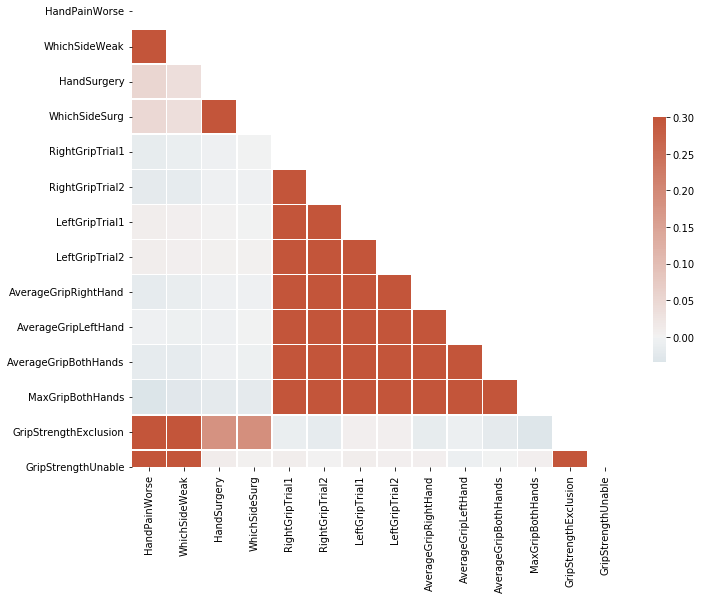

In [13]:
# Create a mask to hide the upper triangle of the correlation matrix (which is symmetric)
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

HandPainWorse and WhichSideWeak have a strong positive correlation of 0.933, indicating that individuals who experience hand pain also tend to have weakness on the same side.
HandSurgery and WhichSideSurg have a high positive correlation of 0.949, suggesting that individuals who had hand surgery often had it on the same side as their weakness.
Grip strength measures (RightGripTrial1, RightGripTrial2, LeftGripTrial1, LeftGripTrial2, AverageGripRightHand, AverageGripLeftHand, AverageGripBothHands, MaxGripBothHands) show moderate to strong positive correlations among themselves, ranging from 0.768 to 0.988. This indicates that grip strength measures are generally consistent across different trials and hands.
GripStrengthExclusion (flag indicating grip strength exclusion criteria) shows a strong positive correlation of 0.919 with HandPainWorse, indicating that individuals with hand pain are more likely to meet the grip strength exclusion criteria.
GripStrengthUnable (flag indicating inability to perform grip strength trials) shows a moderate positive correlation of 0.543 with HandPainWorse, suggesting that individuals with hand pain are more likely to be unable to perform grip strength tests.